<a href="https://colab.research.google.com/github/buczekEngineering/Stroke-Prediction-Application/blob/main/Data_Processing_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Science Project 
Workflow

    Handling missing values
    Outliers Detection: graphical, mathematical
    Labels Encoding
    Feature Selection
    Feature Importance
    Building a model


In [105]:
import numpy as np 
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

In [106]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
data_original = pd.read_csv("/content/drive/MyDrive/Stroke_Prediction/healthcare-dataset-stroke-data.csv")
data = data_original.copy()

# Handling missing values

In [108]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

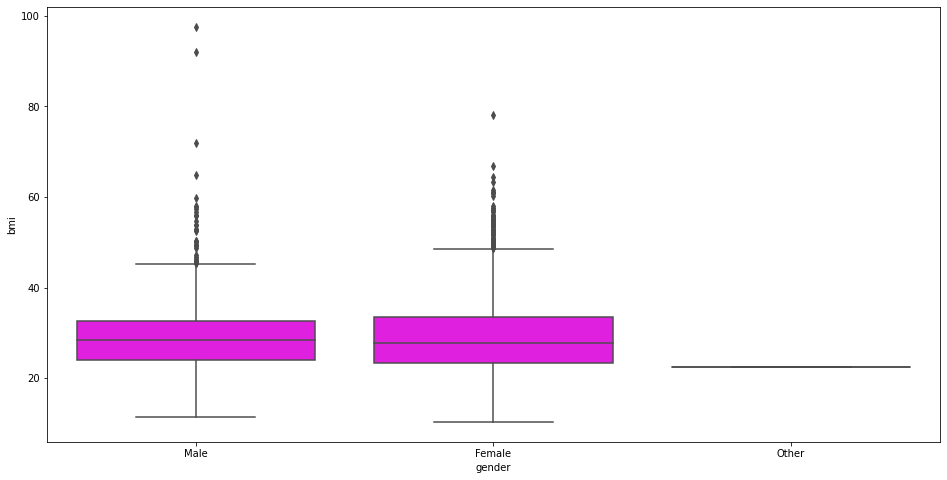

In [109]:
# we habe 201 missing values in bmi
# womans and mans usually have a different mean, max, min and quartile in bmi parameter. This will be checked below using boxplot
import seaborn as sns
plt.figure(figsize=(16,8))
sns.boxplot(x=data["gender"], y=data["bmi"], color="magenta")

On the boxplot we can observe that the mean value for womans and mans are quite close, so we can probably replace the missing value based on the general bmi value. But first we should check these values more accurately 

In [110]:
print("The mean value of BMI for Mans:",np.mean(data[data["gender"]=="Male"]["bmi"]))

The mean value of BMI for Mans: 28.647936350074616


In [111]:
print("The mean value of BMI for Womans:",np.mean(data[data["gender"]=="Female"]["bmi"]))

The mean value of BMI for Womans: 29.065757680359038


In [112]:
mean_bmi = np.mean(data["bmi"])
print("The mean value of BMI in the dataset:", mean_bmi)

The mean value of BMI in the dataset: 28.893236911794673


Replace the missing BMI value with general mean of bmi in the dataset 

In [113]:
data["bmi"] = data["bmi"].fillna(mean_bmi)

In [114]:
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# Outliers Detection: graphical, mathematical

A great method for graphical outliers detection is boxplot. We will search for an outlier in continuos variable.

In [115]:
conti_vars =["age", "bmi", "avg_glucose_level"]

In [116]:
def plot_desc_analytics(df, column_name):
  plt.figure(figsize=(16,8))
  plt.title(column_name)
  sns.boxplot(df[column_name], color="magenta")
  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


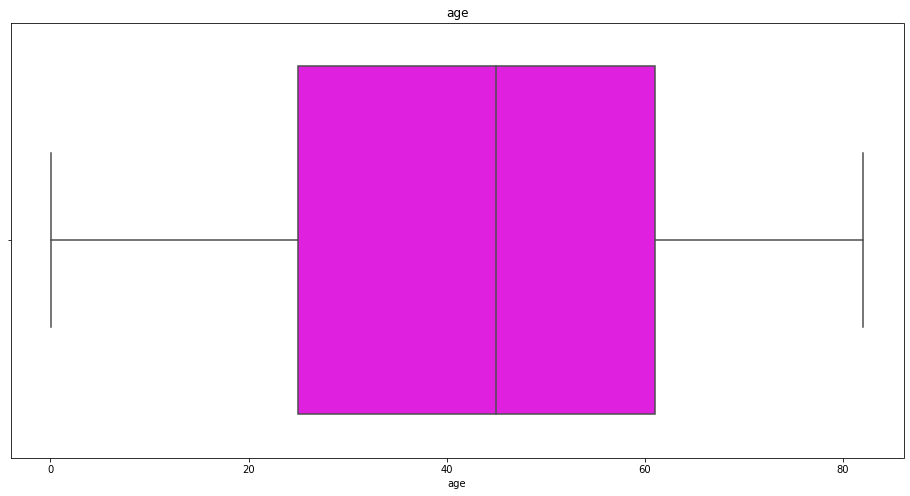

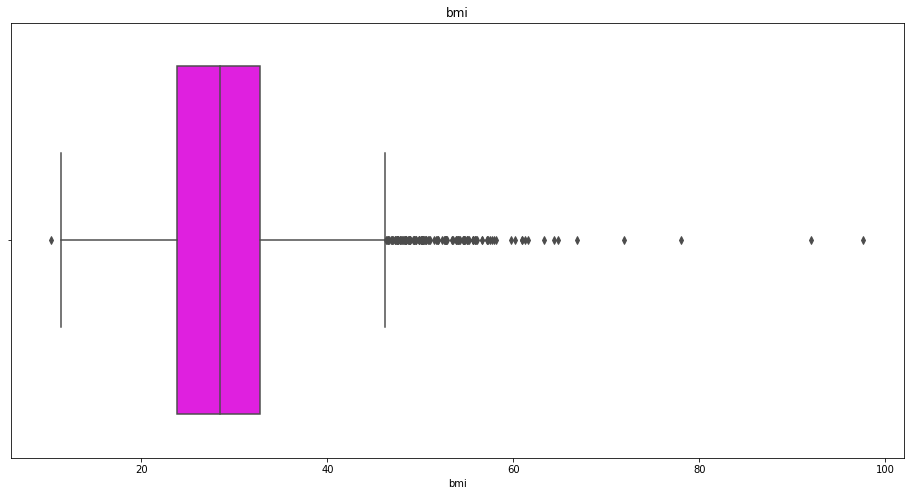

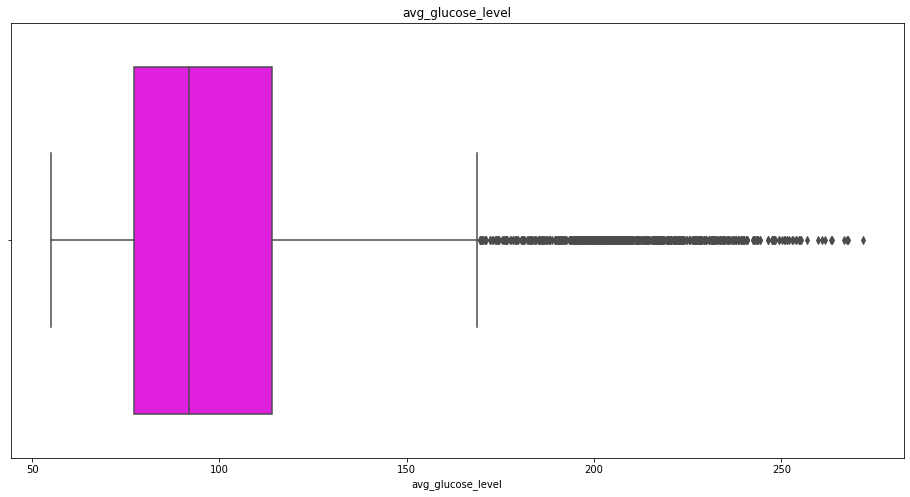

In [117]:
for col in conti_vars:
  plot_desc_analytics(data, col)

Based on the graphical represention we have outliers in "BMI" and in "Avg_glucose_level"

In [118]:
def get_quantile(data:pd.DataFrame, col_name:str): 
  q1 = data[col_name].quantile(0.25)
  q3 = data[col_name].quantile(0.75)
  return q1, q3

def get_thresholds(data:pd.DataFrame, q1:float, q3:float, iqr:float):
  lower_t = q1 - 1.5*iqr
  upper_t = q3 + 1.5*iqr
  return lower_t, upper_t

In [119]:
q1, q3 = get_quantile(data=data, col_name="avg_glucose_level")
lower_t, upper_t = get_thresholds(data=data, q1=q1, q3=q3, iqr=q3-q1) 
outliers_glu = data.query("avg_glucose_level > @upper_t or avg_glucose_level < @lower_t")
print(outliers_glu)

         id  gender   age  ...        bmi   smoking_status stroke
0      9046    Male  67.0  ...  36.600000  formerly smoked      1
1     51676  Female  61.0  ...  28.893237     never smoked      1
3     60182  Female  49.0  ...  34.400000           smokes      1
4      1665  Female  79.0  ...  24.000000     never smoked      1
5     56669    Male  81.0  ...  29.000000  formerly smoked      1
...     ...     ...   ...  ...        ...              ...    ...
5061  38009    Male  41.0  ...  32.300000     never smoked      0
5062  11184  Female  82.0  ...  36.900000     never smoked      0
5063  68967    Male  39.0  ...  27.700000          Unknown      0
5064  66684    Male  70.0  ...  24.300000          Unknown      0
5076  39935  Female  34.0  ...  23.000000     never smoked      0

[627 rows x 12 columns]


In [120]:
# remove the row with outliers in avg_glucose_level
data = data[(data["avg_glucose_level"]> lower_t) & (data["avg_glucose_level"]<upper_t)]
data.shape

(4483, 12)

In [121]:
q1, q3 = get_quantile(data=data, col_name="bmi")
lower_t, upper_t = get_thresholds(data=data, q1=q1, q3=q3, iqr=q3-q1) 
outliers_bmi = data.query("bmi > @upper_t or bmi < @lower_t")
print(outliers_bmi)

         id  gender   age  ...   bmi   smoking_status stroke
79    42117    Male  43.0  ...  45.9          Unknown      1
270   72911  Female  57.0  ...  60.9           smokes      0
333    1703  Female  52.0  ...  54.7  formerly smoked      0
341   38805  Female  37.0  ...  48.2  formerly smoked      0
358   66333    Male  52.0  ...  64.8     never smoked      0
...     ...     ...   ...  ...   ...              ...    ...
4906  72696  Female  53.0  ...  54.1     never smoked      0
4976  63656  Female  18.0  ...  46.0  formerly smoked      0
5009  40732  Female  50.0  ...  49.5  formerly smoked      0
5057  38349  Female  49.0  ...  47.6     never smoked      0
5103  22127  Female  18.0  ...  46.9          Unknown      0

[100 rows x 12 columns]


In [122]:
data = data[(data["bmi"]> lower_t) & (data["bmi"]< upper_t)]
data.shape

(4383, 12)

Double check the distrubution of the data without outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


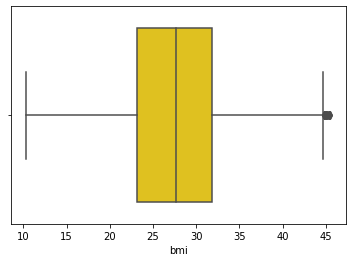

In [123]:
sns.boxplot(data["bmi"], color="gold")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


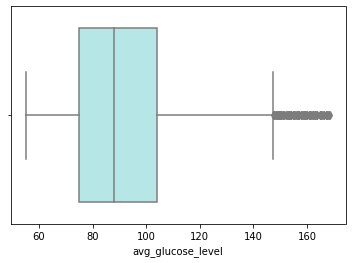

In [124]:
sns.boxplot(data["avg_glucose_level"], color="paleturquoise")

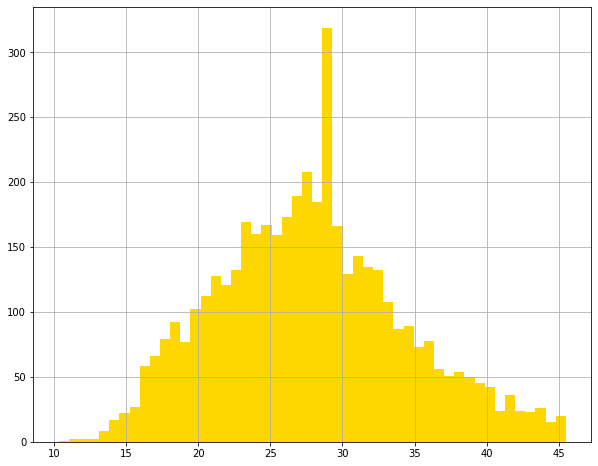

In [125]:
data["bmi"].hist(bins=50, figsize=(10,8), color = "gold")

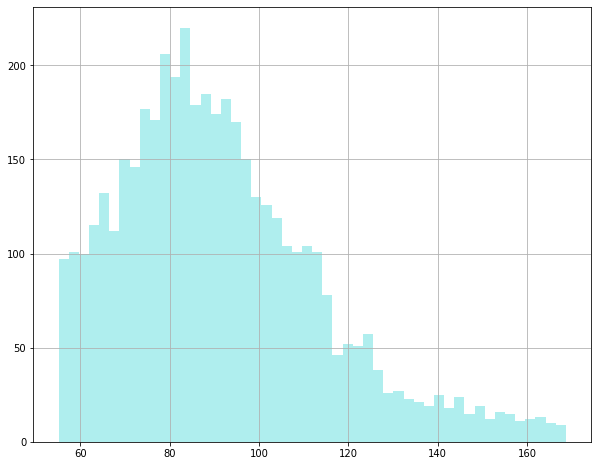

In [126]:
data["avg_glucose_level"].hist(bins=50, figsize=(10,8), color="paleturquoise")

# Encoding Categorical Features

Encoding with numerical data can be done only on binary data, 
if we have more then two categories we should use one hot encoding. Sklearn makes the fundamental assumption that numerical features reflects algebraic quantities. 

In [127]:
# list all categorical variables
cat_var = [cat for cat in data.columns if data[cat].dtypes =="O"]
cat_var

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [128]:
# check how many unique entries are in aformentioned categorical variables
for col in cat_var:
  print("Feature {} has {} unique entries: {}".format(col, len(data[col].unique()), data[col].unique()))

Feature gender has 3 unique entries: ['Male' 'Female' 'Other']
Feature ever_married has 2 unique entries: ['Yes' 'No']
Feature work_type has 5 unique entries: ['Private' 'Govt_job' 'Self-employed' 'children' 'Never_worked']
Feature Residence_type has 2 unique entries: ['Rural' 'Urban']
Feature smoking_status has 4 unique entries: ['never smoked' 'Unknown' 'smokes' 'formerly smoked']


In [129]:
# we can do numerical/binary encoding for ever_married and Residence_type
married_map = {"No": 0, "Yes":1}
residence_map = {"Rural":0, "Urban":1}

data["ever_married"] = data["ever_married"].replace(married_map)
data["Residence_type"]= data["Residence_type"].replace(residence_map)

data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,31112,Male,80.0,0,1,1,Private,0,105.92,32.500000,never smoked,1
6,53882,Male,74.0,1,1,1,Private,0,70.09,27.400000,never smoked,1
7,10434,Female,69.0,0,0,0,Private,1,94.39,22.800000,never smoked,1
8,27419,Female,59.0,0,0,1,Private,0,76.15,28.893237,Unknown,1
9,60491,Female,78.0,0,0,1,Private,1,58.57,24.200000,Unknown,1


One-hot Encoding on columns: "Gender, "Work_type", "Smoking_status"

In [130]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder() 

In [131]:
data['gender'] = pd.Categorical(data['gender'])
dummy_gender = pd.get_dummies(data['gender'], prefix = 'gender_encoded')
dummy_gender

,gender_encoded_Female,gender_encoded_Male,gender_encoded_Other
2,0,1,0
6,0,1,0
7,1,0,0
8,1,0,0
9,1,0,0
...,...,...,...
5105,1,0,0
5106,1,0,0
5107,1,0,0
5108,0,1,0


In [132]:
data['work_type'] = pd.Categorical(data['work_type'])
dummy_work_type = pd.get_dummies(data['work_type'], prefix = 'work_type_encoded')
dummy_work_type

,work_type_encoded_Govt_job,work_type_encoded_Never_worked,work_type_encoded_Private,work_type_encoded_Self-employed,work_type_encoded_children
2,0,0,1,0,0
6,0,0,1,0,0
7,0,0,1,0,0
8,0,0,1,0,0
9,0,0,1,0,0
...,...,...,...,...,...
5105,0,0,1,0,0
5106,0,0,0,1,0
5107,0,0,0,1,0
5108,0,0,1,0,0


In [133]:
data['smoking_status'] = pd.Categorical(data['smoking_status'])
dummy_smoking = pd.get_dummies(data['smoking_status'], prefix = 'smoking_status_encoded')
dummy_smoking

,smoking_status_encoded_Unknown,smoking_status_encoded_formerly smoked,smoking_status_encoded_never smoked,smoking_status_encoded_smokes
2,0,0,1,0
6,0,0,1,0
7,0,0,1,0
8,1,0,0,0
9,1,0,0,0
...,...,...,...,...
5105,0,0,1,0
5106,0,0,1,0
5107,0,0,1,0
5108,0,1,0,0


In [134]:
data.drop("gender", axis=1, inplace=True)
data.drop("smoking_status", axis=1, inplace=True)
data.drop("work_type", axis=1, inplace=True)

In [135]:
data.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
2,31112,80.0,0,1,1,0,105.92,32.500000,1
6,53882,74.0,1,1,1,0,70.09,27.400000,1
7,10434,69.0,0,0,0,1,94.39,22.800000,1
8,27419,59.0,0,0,1,0,76.15,28.893237,1
9,60491,78.0,0,0,1,1,58.57,24.200000,1


In [136]:
data=pd.concat([data, dummy_gender], axis=1)
data=pd.concat([data, dummy_smoking], axis=1)
data=pd.concat([data, dummy_work_type], axis=1)
data.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'gender_encoded_Female', 'gender_encoded_Male', 'gender_encoded_Other',
       'smoking_status_encoded_Unknown',
       'smoking_status_encoded_formerly smoked',
       'smoking_status_encoded_never smoked', 'smoking_status_encoded_smokes',
       'work_type_encoded_Govt_job', 'work_type_encoded_Never_worked',
       'work_type_encoded_Private', 'work_type_encoded_Self-employed',
       'work_type_encoded_children'],
      dtype='object')

In [137]:
data.dtypes

id                                          int64
age                                       float64
hypertension                                int64
heart_disease                               int64
ever_married                                int64
Residence_type                              int64
avg_glucose_level                         float64
bmi                                       float64
stroke                                      int64
gender_encoded_Female                       uint8
gender_encoded_Male                         uint8
gender_encoded_Other                        uint8
smoking_status_encoded_Unknown              uint8
smoking_status_encoded_formerly smoked      uint8
smoking_status_encoded_never smoked         uint8
smoking_status_encoded_smokes               uint8
work_type_encoded_Govt_job                  uint8
work_type_encoded_Never_worked              uint8
work_type_encoded_Private                   uint8
work_type_encoded_Self-employed             uint8


All data is numerical, ready for machine learning.

# Feature Selection

In [138]:
from sklearn.feature_selection import SelectKBest, chi2

In [139]:
data.drop("id", axis=1, inplace=True)

In [141]:
features = data.loc[:,data.columns !="stroke"]
target = data.loc[:,"stroke"]

In [146]:
print("Shape of features: {}".format(features.shape))
print("Shape of target: {}".format(target.shape))

Shape of features: (4383, 19)
Shape of target: (4383,)


In [147]:
selector = SelectKBest(score_func=chi2, k=10)
best_features = selector.fit(features, target)

In [148]:
print(best_features.scores_)

[2.82532168e+03 5.23894752e+01 3.42401694e+01 1.45705770e+01
 1.75152287e-01 3.49121622e-04 7.05163389e+00 1.74956871e-02
 2.37136392e-02 3.88717706e-02 7.85346166e+00 1.65776736e+01
 4.28965751e-02 4.52536062e-02 7.39428899e-03 8.55178952e-01
 1.41142164e-03 2.29551641e+01 2.22474883e+01]


In [151]:
features_df=pd.DataFrame(features.columns, columns=["Features"])
scores_df=pd.DataFrame(best_features.scores_, columns=["Scores"])
best_features_df = pd.concat([features_df, scores_df], axis=1)
best_features_df.sort_values(by="Scores", ascending=False)

,Features,Scores
0,age,2825.321683
1,hypertension,52.389475
2,heart_disease,34.240169
17,work_type_encoded_Self-employed,22.955164
18,work_type_encoded_children,22.247488
11,smoking_status_encoded_formerly smoked,16.577674
3,ever_married,14.570577
10,smoking_status_encoded_Unknown,7.853462
6,bmi,7.051634
15,work_type_encoded_Never_worked,0.855179


In [152]:
best_features_df.nlargest(3, "Scores")

,Features,Scores
0,age,2825.321683
1,hypertension,52.389475
2,heart_disease,34.240169


Feature Importance

In [153]:
from sklearn.ensemble import ExtraTreesClassifier

In [154]:
et_clf = ExtraTreesClassifier()
et_clf.fit(features, target)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [157]:
feature_impo = et_clf.feature_importances_
importance_df = pd.DataFrame(feature_impo, columns=["Importance"])
feature_importance_df = pd.concat([features_df, importance_df], axis=1)
feature_importance_df.sort_values(by="Importance", ascending=False)

,Features,Importance
0,age,2.730382e-01
5,avg_glucose_level,2.602295e-01
6,bmi,2.326687e-01
4,Residence_type,4.178681e-02
1,hypertension,2.626426e-02
3,ever_married,2.036890e-02
2,heart_disease,1.801550e-02
8,gender_encoded_Male,1.616691e-02
12,smoking_status_encoded_never smoked,1.594881e-02
7,gender_encoded_Female,1.589175e-02


In [158]:
feature_importance_df.nlargest(3, "Importance")

,Features,Importance
0,age,0.273038
5,avg_glucose_level,0.260230
6,bmi,0.232669


# Building a Model

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [165]:
# pick selected feature or the feature with high importance
best_features = feature_importance_df.nlargest(7, "Importance")["Features"].unique()
best_features

array(['age', 'avg_glucose_level', 'bmi', 'Residence_type',
       'hypertension', 'ever_married', 'heart_disease'], dtype=object)

In [169]:
features_selected = data[['age', 'avg_glucose_level', 'bmi', 'Residence_type','hypertension', 'ever_married', 'heart_disease']]
print(features_selected)

       age  avg_glucose_level  ...  ever_married  heart_disease
2     80.0             105.92  ...             1              1
6     74.0              70.09  ...             1              1
7     69.0              94.39  ...             0              0
8     59.0              76.15  ...             1              0
9     78.0              58.57  ...             1              0
...    ...                ...  ...           ...            ...
5105  80.0              83.75  ...             1              0
5106  81.0             125.20  ...             1              0
5107  35.0              82.99  ...             1              0
5108  51.0             166.29  ...             1              0
5109  44.0              85.28  ...             1              0

[4383 rows x 7 columns]


In [172]:
# data using selected fatures
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(features_selected, target, test_size=0.2, random_state=0)

In [173]:
# data using all features
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)